<h1><center>RFM</center></h1>

Import library

In [3]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import silhouette_score

Import data

In [4]:
path = 'D:\Giáo Trình\Kỳ 5\Kho và Khai Phá Dữ Liệu\Project'
df = pd.read_csv(os.path.join(path, 'Data\\Processed Data\\order_data.csv'))
df.head(5)

,order_id,order_item_id,customer_unique_id,product_id,seller_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,price,freight_value,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,871766c5855e863f6eccc05f988b23cb,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,delivered,2017-09-13 08:59:02,2017-09-20 23:43:48,2017-09-29 00:00:00,58.90,13.29,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,eb28e67c4c0b83846050ddfb8a35d051,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,delivered,2017-04-26 10:53:06,2017-05-12 16:04:24,2017-05-15 00:00:00,239.90,19.93,259.83
2,000229ec398224ef6ca0657da4fc703e,1,3818d81c6709e39d06b2738a8d3a2474,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,delivered,2018-01-14 14:33:31,2018-01-22 13:19:16,2018-02-05 00:00:00,199.00,17.87,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,af861d436cfc08b2c2ddefd0ba074622,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,delivered,2018-08-08 10:00:35,2018-08-14 13:32:39,2018-08-20 00:00:00,12.99,12.79,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,64b576fb70d441e8f1b2d7d446e483c5,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,delivered,2017-02-04 13:57:51,2017-03-01 16:42:31,2017-03-17 00:00:00,199.90,18.14,218.04


### Drop null

In [5]:
df.isnull().sum()

order_id                            0
order_item_id                       0
customer_unique_id                  0
product_id                          0
seller_id                           0
order_status                        0
order_purchase_timestamp            0
order_delivered_customer_date    2454
order_estimated_delivery_date       0
price                               0
freight_value                       0
payment_value                       3
dtype: int64

Most of null values are in unnecessary column => no need to drop

### Drop duplicate

In [6]:
df.duplicated().sum()

0

### Recency

In [7]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'],format='%Y/%m/%d %H:%M')
df['Diff'] = max(df['order_purchase_timestamp']) - df['order_purchase_timestamp']
recency = df.groupby('customer_unique_id')['Diff'].min().reset_index()
recency['Diff'] = recency['Diff'].dt.days
recency.head()

,customer_unique_id,Diff
0,0000366f3b9a7992bf8c76cfdf3221e2,115
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118
2,0000f46a3911fa3c0805444483337064,541
3,0000f6ccb0745a6a4b88665a16c9f078,325
4,0004aac84e0df4da2b147fca70cf8255,292


In [8]:
recency.columns = ['Customer Id', 'Recency']
recency.head()

,Customer Id,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,115
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118
2,0000f46a3911fa3c0805444483337064,541
3,0000f6ccb0745a6a4b88665a16c9f078,325
4,0004aac84e0df4da2b147fca70cf8255,292


### Frequency

In [9]:
frequency = df.groupby('customer_unique_id')['order_id'].count().reset_index()
frequency.columns = ['Customer Id', 'Frequency']
frequency.head()

,Customer Id,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


### Monetary

In [10]:
monetary = df.groupby('customer_unique_id')['payment_value'].sum().reset_index()
monetary.columns = ['Customer Id', 'Monetary']
monetary.head()

,Customer Id,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89


### RFM 

In [11]:
rfm_temp = pd.merge(recency, frequency, on = 'Customer Id', how = 'inner')
rfm = pd.merge(rfm_temp, monetary, how = 'inner', on = 'Customer Id')
rfm

,Customer Id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19
2,0000f46a3911fa3c0805444483337064,541,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,325,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,292,1,196.89
...,...,...,...,...
95415,fffcf5a5ff07b0908bd4e2dbc735a684,451,2,4134.84
95416,fffea47cd6d3cc0a88bd621562a9d061,266,1,84.58
95417,ffff371b4d645b6ecea244b27531430a,572,1,112.46
95418,ffff5962728ec6157033ef9805bacc48,123,1,133.69


### Standalization

In [12]:
scaler = StandardScaler()
rfm[['Recency', 'Frequency', 'Monetary']] = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])
rfm.head()
rfm = rfm[rfm['Customer Id'] != '0a0a92112bd4c708ca5fde585afaa872'] #outlier 

# Choose K 

### Elbow method

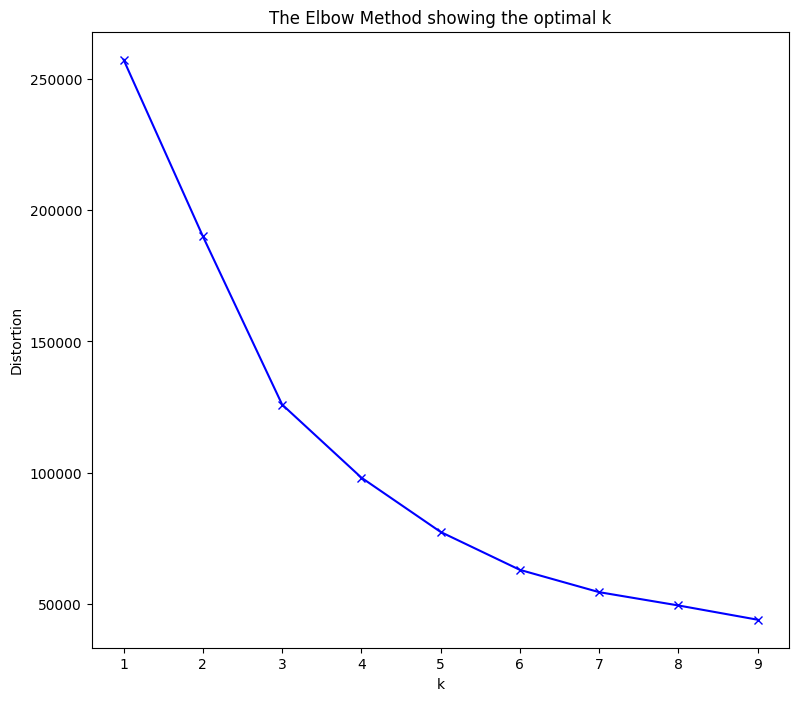

In [12]:
distortions = []
for k in range(1, 10):
    kmeanModel = KMeans(n_clusters = k)
    kmeanModel.fit(rfm[['Recency', 'Frequency', 'Monetary']])
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(9,8))
plt.plot(range(1, 10), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

K = 5

### Silhoutte method

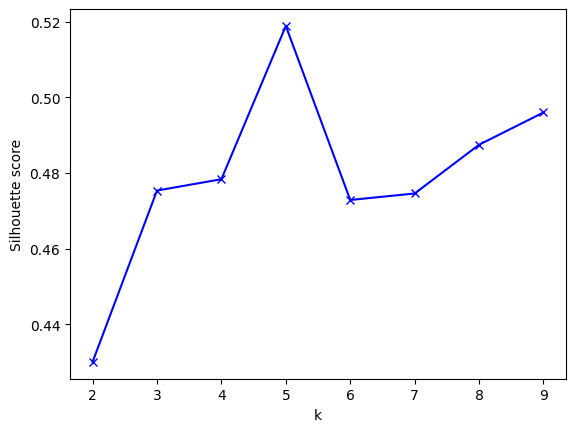

In [19]:
# silhouette_avg = []
# for num_clusters in range(2, 10):
#     kmeans = KMeans(n_clusters=num_clusters)
#     kmeans.fit(rfm[['Recency', 'Frequency', 'Monetary']])
#     cluster_labels = kmeans.labels_
#     silhouette_avg.append(silhouette_score(rfm[['Recency', 'Frequency', 'Monetary']], cluster_labels))
# plt.plot(range(2, 10),silhouette_avg, 'bx-')
# plt.xlabel('k') 
# plt.ylabel('Silhouette score') 
# plt.show()

K = 5

### Gap Statistic method

Optimal k is:  7


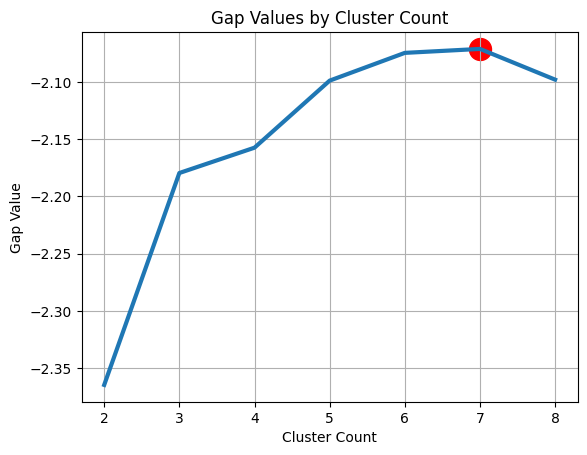

In [29]:
import warnings
warnings.filterwarnings("ignore")
def optimalK(data, nrefs=3, maxClusters=9):
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(2, maxClusters)):
        refDisps = np.zeros(nrefs)
        for i in range(nrefs):
            randomReference = np.random.random_sample(size=data.shape)
            km = KMeans(k)
            km.fit(randomReference)
            refDisp = km.inertia_
            refDisps[i] = refDisp
        km = KMeans(k)
        km.fit(data)
        origDisp = km.inertia_
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        gaps[gap_index] = gap
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
    return (gaps.argmax(), resultsdf)
k, gapdf = optimalK(rfm[['Recency', 'Frequency', 'Monetary']])
print('Optimal k is: ', k)
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

==> Choose K = 5

### Apply Model

In [27]:
rfm_model = rfm[['Recency', 'Frequency', 'Monetary']].values
clust = 5
model = KMeans(n_clusters = clust).fit(rfm_model)
pred_label = model.predict(rfm_model)
rfm['Cluster Id'] = pred_label

C:\Users\quoct\AppData\Local\Temp\ipykernel_14308\1400493418.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm['Cluster Id'] = pred_label


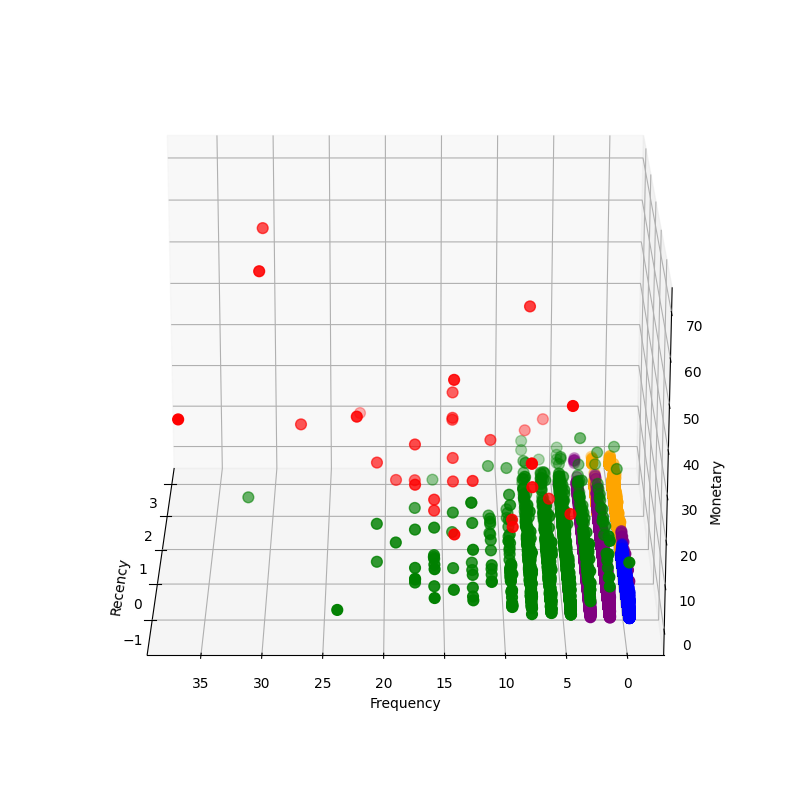

In [28]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111, projection='3d')
colorList = ['blue', 'orange', 'green', 'red', 'purple']
for i in range(clust) : 
  ax.scatter3D(rfm_model[pred_label == i, 0], rfm_model[pred_label == i, 1], rfm_model[pred_label == i, 2], c = colorList[i], s = 60)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.view_init(20, 180)
plt.show()

### Recency

<AxesSubplot: xlabel='Cluster Id', ylabel='Recency'>

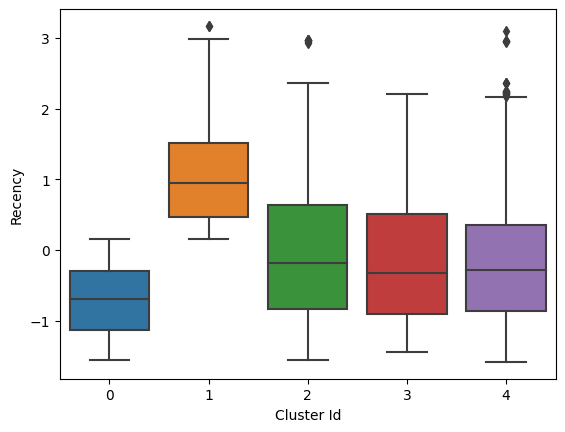

In [29]:
sns.boxplot(x = 'Cluster Id', y = 'Recency', data = rfm)

### Frequency

<AxesSubplot: xlabel='Cluster Id', ylabel='Frequency'>

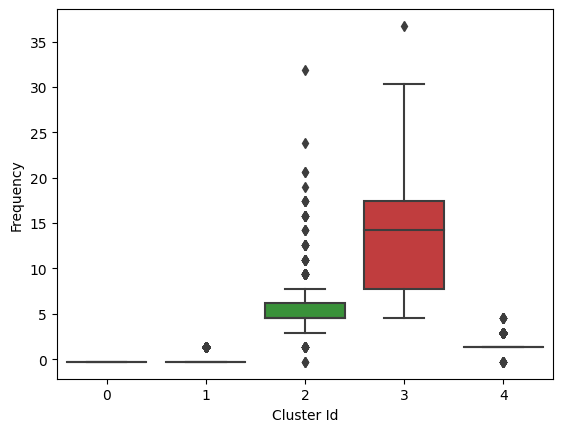

In [31]:
sns.boxplot(x = 'Cluster Id', y = 'Frequency', data = rfm)

### Monetary

<AxesSubplot: xlabel='Cluster Id', ylabel='Monetary'>

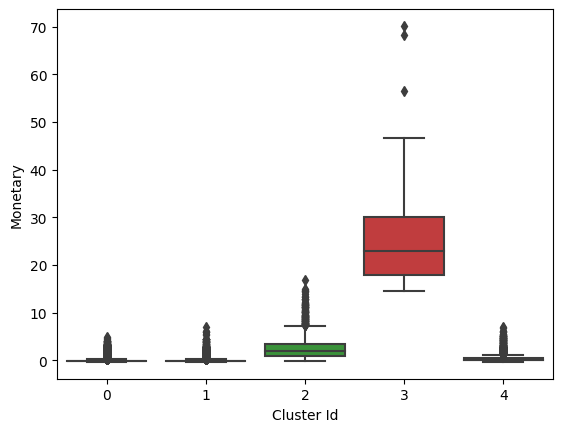

In [32]:
sns.boxplot(x = 'Cluster Id', y = 'Monetary', data = rfm)

In [33]:
rfm['Cluster Name'] = rfm['Cluster Id'].map({0: 'Promising', 1: 'Lost', 2: 'Loyal customers', 3: 'Champions', 4 : 'Need Attention'})
rfm

C:\Users\quoct\AppData\Local\Temp\ipykernel_14308\3475614403.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm['Cluster Name'] = rfm['Cluster Id'].map({0: 'Promising', 1: 'Lost', 2: 'Loyal customers', 3: 'Champions', 4 : 'Need Attention'})


,Customer Id,Recency,Frequency,Monetary,Cluster Id,Cluster Name
0,0000366f3b9a7992bf8c76cfdf3221e2,-0.833121,-0.290564,-0.110523,0,Promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-0.813533,-0.290564,-0.289267,0,Promising
2,0000f46a3911fa3c0805444483337064,1.948293,-0.290564,-0.197285,1,Lost
3,0000f6ccb0745a6a4b88665a16c9f078,0.537999,-0.290564,-0.263665,1,Lost
4,0004aac84e0df4da2b147fca70cf8255,0.322537,-0.290564,-0.024836,1,Lost
...,...,...,...,...,...,...
95415,fffcf5a5ff07b0908bd4e2dbc735a684,1.360670,1.318585,6.111367,2,Loyal customers
95416,fffea47cd6d3cc0a88bd621562a9d061,0.152779,-0.290564,-0.199840,0,Promising
95417,ffff371b4d645b6ecea244b27531430a,2.150696,-0.290564,-0.156397,1,Lost
95418,ffff5962728ec6157033ef9805bacc48,-0.780888,-0.290564,-0.123316,0,Promising


In [34]:
rfm.to_csv(path + "\Web App\\Data\\rfm.csv", index = False)

**What does each cluster represent?**

* **Cluster 0** : This cluster can be interpreted as (Promising) as their spending is the smallest among all clusters but have the lowest recency. This cluster is quite huge. So, some marketing effort could be advisable towards it in order to increase its monetary value.

* **Cluster 1** : (Lost) is the name we can give to this cluster. Customers in this cluster seem have one of the highest recency and their monetary value is low. This cluster shouldn't be the focus of marketing effort.

* **Cluster 2** : can be considered as our best one (Loyal customers) since although customers in this cluster haven't on avergae ordered in a while, their frequency of orders is greater than all other clusters and the value of their orders is quite high.

* **Cluster 3** : This is our second best (Champions) cluster as it's recency comes second and the average amount spent is largest. This cluster is also second in terms of number of customers.

* **Cluster 4** : (Need Attention) This cluster is between Loyal customer and Promising customer, have monetary and frequency higher than average. Need more marketing strategy to improve their loyalty.